In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

from EfficientQAT.quantize.int_linear_fake import QuantLinear
# Parameters
input_dim = 3
output_dim = 1
num_samples = 320
device = torch.device("cuda:5")

torch.manual_seed(2)

# Generating synthetic data
X = torch.randn(num_samples, input_dim)*7  # Input features
# true_weights = torch.randn(input_dim, output_dim)*1.2  # True weights
true_weights = torch.tensor([[4] ,[1.8],[0.03]])

# true_bias = torch.randn(output_dim)  # True bias
y = X @ true_weights + torch.randn_like(X @ true_weights) * 0.0005  # Adding noise


# Creating dataset and dataloader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Defining a linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.in_features = input_dim
        self.out_features = output_dim
        self.group_size = 3
        self.linear = QuantLinear(self.linear, wbits=2, group_size=self.group_size,args={
            "gradual_quant":True,
            # "iterative_freezing":True,
            "freeze_threshold":1.0
        })
        self.linear.bias = None
        self.linear.set_quant_state(True)
        # print(self.linear.weight_quantizer.scale)
        # print(self.linear.weight.amin([-1], keepdim=True))
        self.bits =2
        self.logs = {
            "steps": [],
            "quant_weight": [],
            "quant_zero_point": [],
            "quant_scale": [],
            "quant_weight2" : [],
            "quant_zero_point2" : [],
            "quant_scale2" : [],
            "quant_weight3" : [],
            "quant_zero_point3" : [],
            "quant_scale3" : [],
            "weight_position":(0,0),
            "weight_position2":(0,1),            
            "weight_position3":(0,2),
        }
        self.step = 0

    def forward(self, x):
        return self.linear(x)
    
    def examine_weights(self):
        prod = self.logs["weight_position"]
        prod = prod[0]*self.in_features + prod[1]
        g_idx = (prod//self.group_size, prod%self.group_size)
        int_weight,scale,zero_point = self.linear.get_inferred_params()

        self.logs["quant_weight"].append(int_weight.reshape(-1,self.group_size)[g_idx].clone().detach().cpu().item())
        self.logs["quant_zero_point"].append(zero_point[g_idx[0]].clone().detach().cpu().item())
        self.logs["quant_scale"].append(scale[g_idx[0]].clone().detach().cpu().item())
        
        prod = self.logs["weight_position2"]
        prod = prod[0]*self.in_features + prod[1]
        g_idx = (prod//self.group_size, prod%self.group_size)
        self.logs["quant_weight2"].append(int_weight.reshape(-1,self.group_size)[g_idx].clone().detach().cpu().item())
        self.logs["quant_zero_point2"].append(zero_point[g_idx[0]].clone().detach().cpu().item())
        self.logs["quant_scale2"].append(scale[g_idx[0]].clone().detach().cpu().item())

        prod = self.logs["weight_position3"]
        prod = prod[0]*self.in_features + prod[1]
        g_idx = (prod//self.group_size, prod%self.group_size)
        self.logs["quant_weight3"].append(int_weight.reshape(-1,self.group_size)[g_idx].clone().detach().cpu().item())
        self.logs["quant_zero_point3"].append(zero_point[g_idx[0]].clone().detach().cpu().item())
        self.logs["quant_scale3"].append(scale[g_idx[0]].clone().detach().cpu().item())
        
        self.logs["steps"].append(self.step)
        self.step += 1

# Initialize the model
model = LinearRegressionModel(input_dim, output_dim)
# Move the model to device
model.to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

loss_list = []

# Train the model
for epoch in range(50):
    running_loss = 0.0
    # if epoch %4:
    for i, data in enumerate(dataloader, 0):
        # for param_group in optimizer.param_groups:
        #     param_group['lr'] = param_group['lr'] / (model.step+1)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            model.examine_weights()
            # print(f"weight1 grad {model.linear.weight.grad} scale grad {model.linear.weight_quantizer.scale.grad} zero_point grad {model.linear.weight_quantizer.zero_point.grad}")
        running_loss += loss.item()
        loss_list.append(loss.item())
    print(f"Epoch {epoch+1} loss: {running_loss/len(dataloader)}")

# Test the model
with torch.no_grad():
    inputs, labels = next(iter(dataloader))
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    # print(f"Test loss: {criterion(outputs, labels)}")

Epoch 1 loss: 355.1421875
Epoch 2 loss: 94.14610271453857
Epoch 3 loss: 34.54685764312744
Epoch 4 loss: 3.002960765361786
Epoch 5 loss: 3.1081764698028564
Epoch 6 loss: 15.855561137199402
Epoch 7 loss: 18.840732741355897
Epoch 8 loss: 20.63053207397461
Epoch 9 loss: 18.311733531951905
Epoch 10 loss: 20.01570854187012


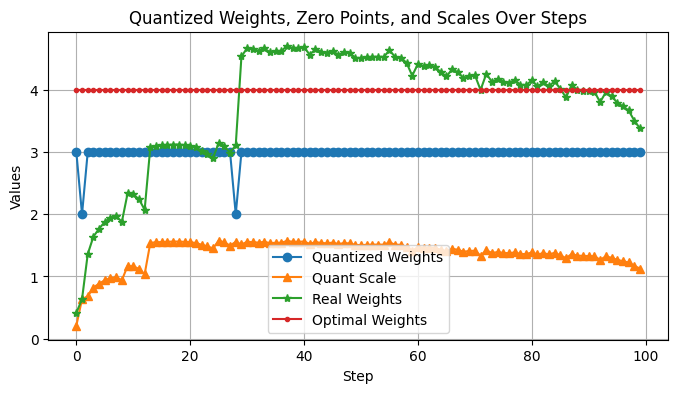

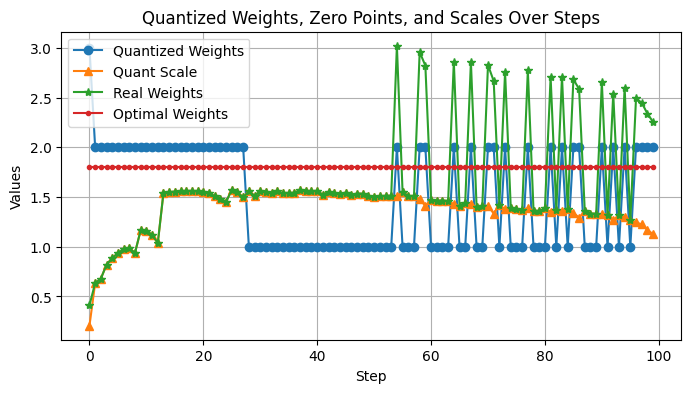

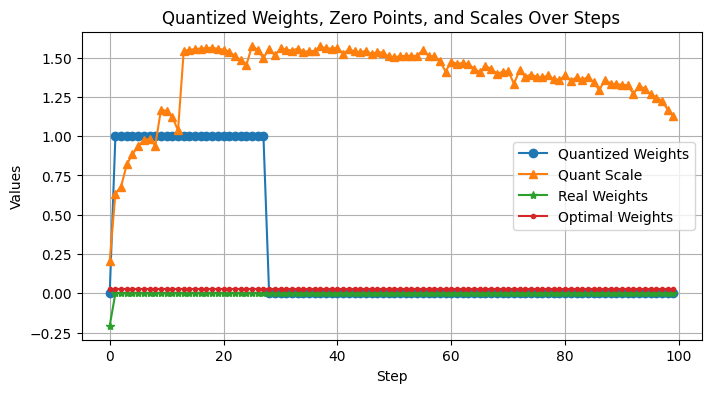

In [2]:
import matplotlib.pyplot as plt
import numpy as np
steps = model.logs["steps"]  # Example step range
quant_weights = model.logs["quant_weight"]  # Example quantized weights
quant_zero_points = model.logs["quant_zero_point"]  # Example zero points
quant_scales = model.logs["quant_scale"]  # Example scales

step = np.array(steps)
quant_weight = np.array(quant_weights)
quant_zero_point = np.array(quant_zero_points)
quant_scale = np.array(quant_scales)
real_weight = (quant_weight-quant_zero_point)*quant_scale
optimal = true_weights[0].item()
optimal = np.array([optimal]*len(step))

# Plotting
plt.figure(figsize=(8,4))
plt.plot(steps, quant_weights, label="Quantized Weights", marker='o')
# plt.plot(steps, quant_zero_points, label="Quant Zero Point", marker='s')
plt.plot(steps, quant_scales, label="Quant Scale", marker='^')
# plt.plot(steps, loss_list, label="Training Loss", marker='x')
plt.plot(steps, real_weight, label="Real Weights", marker='*')
plt.plot(steps, optimal, label="Optimal Weights", marker='.')
plt.xlabel("Step")
plt.ylabel("Values")
plt.title("Quantized Weights, Zero Points, and Scales Over Steps")
plt.legend()
plt.grid(True)
plt.show()

quant_weights = model.logs["quant_weight2"]  # Example quantized weights
quant_zero_points = model.logs["quant_zero_point2"]  # Example zero points
quant_scales = model.logs["quant_scale2"]  # Example scales

step = np.array(steps)
quant_weight = np.array(quant_weights)
quant_zero_point = np.array(quant_zero_points)
quant_scale = np.array(quant_scales)
real_weight = (quant_weight-quant_zero_point)*quant_scale
optimal = true_weights[1,0].item()
optimal = np.array([optimal]*len(step))
# Plotting
plt.figure(figsize=(8,4))
plt.plot(steps, quant_weights, label="Quantized Weights", marker='o')
# plt.plot(steps, quant_zero_points, label="Quant Zero Point", marker='s')
plt.plot(steps, quant_scales, label="Quant Scale", marker='^')
# plt.plot(steps, loss_list, label="Training Loss", marker='x')
plt.plot(steps, real_weight, label="Real Weights", marker='*')
plt.plot(steps, optimal, label="Optimal Weights", marker='.')
plt.xlabel("Step")
plt.ylabel("Values")
plt.title("Quantized Weights, Zero Points, and Scales Over Steps")
plt.legend()
plt.grid(True)
plt.show()

quant_weights = model.logs["quant_weight3"]  # Example quantized weights
quant_zero_points = model.logs["quant_zero_point3"]  # Example zero points
quant_scales = model.logs["quant_scale3"]  # Example scales

step = np.array(steps)
quant_weight = np.array(quant_weights)
quant_zero_point = np.array(quant_zero_points)
quant_scale = np.array(quant_scales)
real_weight = (quant_weight-quant_zero_point)*quant_scale
optimal = true_weights[2,0].item()
optimal = np.array([optimal]*len(step))
# Plotting
plt.figure(figsize=(8,4))
plt.plot(steps, quant_weights, label="Quantized Weights", marker='o')
# plt.plot(steps, quant_zero_points, label="Quant Zero Point", marker='s')
plt.plot(steps, quant_scales, label="Quant Scale", marker='^')
# plt.plot(steps, loss_list, label="Training Loss", marker='x')
plt.plot(steps, real_weight, label="Real Weights", marker='*')
plt.plot(steps, optimal, label="Optimal Weights", marker='.')
plt.xlabel("Step")
plt.ylabel("Values")
plt.title("Quantized Weights, Zero Points, and Scales Over Steps")
plt.legend()
plt.grid(True)
plt.show()
